In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import json
import transformers
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, TrainingArguments, Trainer, AutoModelForMaskedLM
import datasets
from datasets import Features, Value, Sequence, load_metric, load_dataset
import torch
from preprocessing_utils import dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import random
import seaborn as sns

/Users/romainbourgeois/miniconda3/lib/python3.8/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [2]:
f = open('data/labelled_data.json')
data = json.load(f)
f = open('data/NERdata.json')
ner = json.load(f)

In [3]:
d=dataset(data,ner, ['PARTNERSHIP','RESEARCH_PROJECT','SUBSIDIARY','PURCHASE','FINANCING','LAUNCH_PRODUCT-SERVICE','HAS_PRODUCT-SERVICE',
'OPERATES_IN_MARKET','BASED_IN','WORKS_IN'],['PARTNERSHIP'])
mr=d.mapped_rel()
datatrain,datatest=d.build_labelled_dataset(0.2)

In [4]:
dataset = load_dataset('json',data_files={'train':'data/reldatatrain.json', 'test': 'data/reldatatest.json'}, field='data')
tokenizer = AutoTokenizer.from_pretrained(os.getcwd()+"/tokenizer_fine_tuned_.pt",local_files_only=True)
model_loaded = AutoModelForMaskedLM.from_pretrained(os.getcwd()+"/fine_tuned_.pt",local_files_only=True, output_hidden_states=True)

Using custom data configuration default-49c1c1d85130f28f
Reusing dataset json (/Users/romainbourgeois/.cache/huggingface/datasets/json/default-49c1c1d85130f28f/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)
100%|██████████| 2/2 [00:00<00:00, 700.28it/s]


In [5]:
labels=['0','PARTNERSHIP','RESEARCH_PROJECT','SUBSIDIARY','PURCHASE','FINANCING','RECRUITMENT','LAUNCH_PRODUCT-SERVICE','HAS_PRODUCT-SERVICE',
'OPERATES_IN_MARKET','BASED_IN','WORKS_IN']

def firsttoken(output):
    return output[0]

def EntTokens(output, reverse, e11, e22):
    if reverse==True:
        return np.concatenate((output[e11],output[e22]),axis=0)
    else:
        return np.concatenate((output[e22],output[e11]),axis=0)

def maxpool_ents(output, reverse, e11, _e11, e22, _e22):
    ee1=output[e11+1:_e11]
    if ee1.shape[0]==0:
        ee1=np.zeros(768)
    elif ee1.shape[0]>1:
        ee1=ee1.max(axis=0)
    else:
        ee1=ee1[0]
    ee2=output[e22+1:_e22]
    if ee2.shape[0]==0:
        ee2=np.zeros(768)
    elif ee2.shape[0]>1:
        ee2=ee2.max(axis=0)
    else:
        ee2=ee2[0]
    if reverse==True:
        return np.concatenate((ee1,ee2),axis=0)
    else:
        return np.concatenate((ee1,ee2),axis=0)

def data(dataset, e1=30873, _e1=30875, e2=30874, _e2=30876): 
    inp=tokenizer(dataset["inputs"], is_split_into_words=True, truncation=True, max_length=512, padding='max_length')
    outputs=model_loaded(torch.tensor(inp['input_ids']).reshape(1,-1))
    output=outputs[-1][-1].detach().numpy()[0,:,:]
    reverse=dataset['head_first']
    label=dataset['label']
    e11=inp['input_ids'].index(e1)
    _e11=inp['input_ids'].index(_e1)
    e22=inp['input_ids'].index(e2)
    _e22=inp['input_ids'].index(_e2)
    l=labels.index(label)
    firsttokendata=firsttoken(output)
    EntTokensdata=EntTokens(output, reverse, e11, e22)
    maxpool_entsdata=maxpool_ents(output, reverse,e11,_e11,e22,_e22)
    return l,firsttokendata,EntTokensdata,maxpool_entsdata

In [6]:
y_train=np.array(data(dataset['train'][0])[0]).reshape(1,-1)
X_train1=data(dataset['train'][0])[1].reshape(1,-1)
X_train2=data(dataset['train'][0])[2].reshape(1,-1)
X_train3=data(dataset['train'][0])[3].reshape(1,-1)

for i in range(len(dataset['train'])):
    o,one,two,three=data(dataset['train'][i])
    y_train=np.concatenate((y_train,np.array(o).reshape(1,-1)),axis=0)
    X_train1=np.concatenate((X_train1,one.reshape(1,-1)),axis=0)
    X_train2=np.concatenate((X_train2,two.reshape(1,-1)),axis=0)
    X_train3=np.concatenate((X_train3,three.reshape(1,-1)),axis=0)

y_test=np.array(data(dataset['test'][0])[0]).reshape(1,-1)
X_test1=data(dataset['test'][0])[1].reshape(1,-1)
X_test2=data(dataset['test'][0])[2].reshape(1,-1)
X_test3=data(dataset['test'][0])[3].reshape(1,-1)

for i in range(len(dataset['test'])):
    o,one,two,three=data(dataset['test'][i])
    y_test=np.concatenate((y_test,np.array(o).reshape(1,-1)),axis=0)
    X_test1=np.concatenate((X_test1,one.reshape(1,-1)),axis=0)
    X_test2=np.concatenate((X_test2,two.reshape(1,-1)),axis=0)
    X_test3=np.concatenate((X_test3,three.reshape(1,-1)),axis=0)


In [7]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train1, y_train)
y_pred=neigh.predict(X_test1)
f1_score(y_test, y_pred, average=None)

/Users/romainbourgeois/miniconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0.8260355 , 0.20664207, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2       , 0.        ])

In [8]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train2, y_train)
y_pred=neigh.predict(X_test2)
f1_score(y_test, y_pred, average=None)

/Users/romainbourgeois/miniconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0.86163142, 0.17857143, 0.        , 0.5       , 0.        ,
       0.        , 0.17142857, 0.15789474, 0.35294118, 0.15384615])

In [14]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train3, y_train)
y_pred=neigh.predict(X_test3)
f1_score(y_test, y_pred, average=None)

/Users/romainbourgeois/miniconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0.82185273, 0.19402985, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23529412, 0.        ])

Solutions for dealing with label 0
* remove some 0 to balance dataset


In [38]:
def kmeans(clusters, train, y_train):
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(train)
    p=kmeans.predict(train)
    cl={}
    for i in range(clusters):
        idx=np.where(p == i)
        cl[str(i)]=idx
    accs=[]
    for k in cl.keys():
        relations=y_train[cl[k]]
        acc=np.unique(relations, return_counts=True)[1].max()/len(relations)
        accs.append(acc)
    accs=np.array(accs)
    score=accs.mean()
    score_std=accs.std()
    return score, score_std



In [39]:
scores=[]
for i in range(2,50):
    score, score_std=kmeans(i, X_train2,y_train)
    scores.append([float(score),float(score_std)])
    #print("for ",i," score mean is ",score," and std is ",score_std)

<AxesSubplot:>

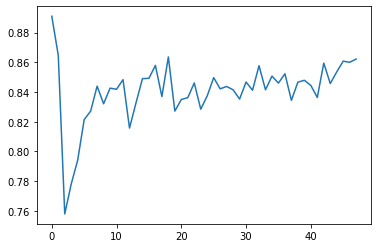

In [65]:
sns.lineplot(data=np.array(scores)[:,0])